### Note: You may need to install `markdown`:

    pip install markdown

In [1]:
%load_ext sql
%sql sqlite://

%load_ext autoreload
%autoreload 2

# To help render markdown
from IPython.core.display import display, HTML
from markdown import markdown
def render_markdown_raw(m): return display(HTML(markdown(m))) # must be last element of cell.
def render_markdown(m): return render_markdown_raw(m.toMD())
def cost_markdown(q): 
    q.reset_count()
    get_result(q) # run the counters
    return display(HTML(markdown("Total Reads: {0}\n\n".format(q.total_count()) + q.toCount(0))))

# import the relational algbera operators
from relation_algebra import Select, Project, Union, NJoin, CrossProduct, BaseRelation
from relation_algebra import get_result, compare_results

from display_tools import side_by_side

import random

/Users/tarabalakrishnan/.local/lib/python2.7/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/Users/tarabalakrishnan/.local/lib/python2.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


In [2]:
%%sql
drop table if exists R; create table R(A int, B int);
drop table if exists S; create table S(B int, C int);
drop table if exists T; create table T(C int, D int);

Done.
Done.
Done.
Done.
Done.
Done.


[]

Activity 17-1: Optimization of Relational Algebra Expressions
==================================



We start by generating some sample data for relations $R$ and $S$:

In [3]:
for b in range(0,5,1):
    for a in range(0,10,2):
        %sql INSERT INTO R VALUES (:a, :b);
for b in range(0,5,1):
    for c in range(0,10,2):
        %sql INSERT INTO S VALUES (:b, :c);
for c in range(0,5,1):
    for d in range(0,10,2):
        %sql INSERT INTO T VALUES (:c, :d);

1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affecte

Then, let's look at the following RA expression:

In [4]:
r = %sql SELECT * FROM R;
R = BaseRelation(r, name="R")
s = %sql SELECT * FROM S;
S = BaseRelation(s, name="S")

x = Project(["B"], NJoin(R,S))
render_markdown(x)
print get_result(x)

Done.
Done.


[(2,), (0,), (3,), (1,), (4,)]


Let's look at what's going on under the hood using the `cost_markdown` function:

In [5]:
cost_markdown(x)

Note that there are several simplifying assumptions in how we compute cost here.  For one, note that we don't assume anything about being able to cache intermediate results in any way (either in buffer or on disk).  For another one, note how is the join done... what algorithm are we using here?

Note that we can also just get the total count of reads:

In [6]:
x.total_count()

775

### Exercise 1: Optimizing the IO Cost

Can you find a logically equivalent form that uses fewer total reads?

In [5]:
y = NJoin(Project(["B"], R), Project(["B"], S))
render_markdown(y)
print compare_results(x,y)
cost_markdown(y)

True


### Exercise 2: Comparing costs

Let's explore how the cost of the two expressions compare as the data size increases, and with different numbers of distinct values in the data.  Given that $R$ has $N$ values, $S$ has $M$ values, you can assume that $N=M$ to simplify, and that they will both have _the same number of unique $B$ values_.

You can do this any way you choose, but we outline one way below:

We'll start with a function for each cost that will take as input:
* The number of tuples in $R$, $N$
* **_The number of distinct $B$ values in $R$, $N_B$_**
* The number of tuples in $R\Join_B S$, $O_1$
* The number of tuples in $\Pi_B(R\Join_B S)$, $O_2$

Your function should return the total number of reads as in the `cost_markdown` function

In [6]:
def cost_simple_nlj(n, m):
    """
    Cost to perform a simple NLJ join
    Assuming 1 tuple / page
    """
    return n + n*m

def cost_1(N, M, N_B, M_B, O_1, O_2):
    
    # The cost of reading in for NLJ over R and S
    cost = cost_simple_nlj(N,M)
    
    # The cost of reading in the output of the join to do the projection
    cost += O_1  
    return cost

def cost_2(N, M, N_B, M_B, O_1, O_2):
    
    # The cost to do the projections
    cost_proj_R = N
    cost_proj_S = M
    
    # The cost of doing the projections for each loop of NLJ
    cost = cost_proj_R + N_B*cost_proj_S
    
    # The cost of doing NLJ
    cost += cost_simple_nlj(N_B, M_B)
    return cost

print cost_1(25, 25, 5, 5, 125, 5)
print cost_2(25, 25, 5, 5, 125, 5)

775
180


We can plot this as a function of $N$ (assume $N=M$ for simplicity), given 5 distinct $B$ values and a rough estimate of the intermediate output counts:

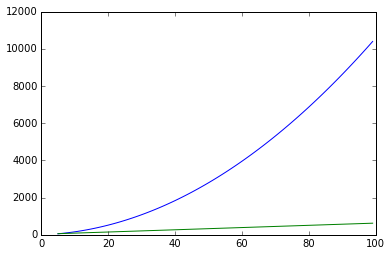

In [8]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

B = 5
nrange = range(5,100)

# Plot
plt.plot(nrange, [cost_1(n, n, B, B, n*B, B) for n in nrange])
plt.plot(nrange, [cost_2(n, n, B, B, n*B, B) for n in nrange])
plt.show()

### Exercise 3: Optimizing some other expressions

Can you optimize the below expressions, using the tools above?

#### Exercise 3.1

In [6]:
x = Select("A", 2, Project(["A","C"], NJoin(R,S)))
render_markdown(x)
print get_result(x)
cost_markdown(x)

[(2, 8), (2, 6), (2, 2), (2, 0), (2, 4)]


In [28]:
y = Project(["A","C"], NJoin(Select("A", 2, R), S))
render_markdown(y)
print get_result(y)
print compare_results(x,y)
cost_markdown(y)

[(2, 0), (2, 6), (2, 8), (2, 4), (2, 2)]
True


#### Exercise 3.2

In [29]:
t = %sql SELECT * FROM T;
T = BaseRelation(t, name="T")

x = Select("C", 0, Project(["A","C"], Select("B", 0, NJoin(NJoin(R, S), T))))
render_markdown(x)
print get_result(x)
cost_markdown(x)

Done.


[(0, 0), (6, 0), (2, 0), (8, 0), (4, 0)]


In [38]:
y = Project(["A","C"], NJoin(
        Select("C", 0, NJoin(Select("B", 0, R), Select("B", 0, S))),
        Project(["C"], Select("C", 0, T))))
render_markdown(y)
print get_result(y)
print compare_results(x,y)
cost_markdown(y)

[(8, 0), (2, 0), (0, 0), (6, 0), (4, 0)]
True
